In [24]:
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from pathlib import Path
import seaborn as sns

sys.path.append(os.path.abspath(os.path.join('../src')))
from constant_drift_diffusion import *
from accumulators import *
from motion_simulation import *

# bayesflow
sys.path.append(os.path.abspath(os.path.join('../../BayesFlow')))
from bayesflow.networks import InvariantNetwork, InvertibleNetwork
from bayesflow.amortizers import SingleModelAmortizer
from bayesflow.trainers import ParameterEstimationTrainer
from bayesflow.diagnostics import *

from tensorflow.keras.layers import Dense, GRU, LSTM, Conv1D, MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.python.keras.utils.np_utils import to_categorical

In [25]:
# gpu_devices = tf.config.experimental.list_physical_devices('GPU')
# for device in gpu_devices: tf.config.experimental.set_memory_growth(device, True)

In [26]:
%load_ext autoreload
%autoreload 2
np.set_printoptions(suppress=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Constants

In [27]:
# simulation 
N_SIM = 500
N_OBS = 100

# bayesflow
PARAM_NAMES = ["a", "ndt", "bias", "kappa"]
N_PARAMS = len(PARAM_NAMES)
N_EPOCHS = 50
ITER_PER_EPOCH = 1000
BATCH_SIZE = 32
N_SAMPLES = 2000

## Simulator Test

In [ ]:
n_obs = 100
a     = 3.0
ndt   = 0.2
bias  = 0.5
kappa = 5
theta = np.array([a, ndt, bias, kappa])

unique_motions = np.array([-0.725, -0.675, -0.625, -0.575, -0.525, 0.525,  0.575,  0.625,  0.675,  0.725], dtype=np.float32)
amplitude = np.repeat(unique_motions, 10)
condition = to_categorical(pd.factorize(amplitude)[0])

rt, resp = const_dm_simulator(theta, n_obs, amplitude)

In [ ]:
np.hstack((np.expand_dims(rt, axis=1), np.expand_dims(resp, axis=1), np.expand_dims(amplitude, axis=1))).shape

In [ ]:
p_, x_ = const_dm_batch_simulator(32, 100)
x_.shape

## BayesFlow

In [28]:
class CustomSummary(tf.keras.Model):
    
    def __init__(self, meta_inv, n_out=10):
        super(CustomSummary, self).__init__()
        self.inv = InvariantNetwork(meta_inv)
        self.out = Dense(n_out)
        
    def call(self, x):
        return self.out(self.inv(x)) 

In [29]:
sum_meta = {
    'n_dense_s1': 2,
    'n_dense_s2': 2,
    'n_dense_s3': 2,
    'n_equiv':    2,
    'dense_s1_args': {'activation': 'relu', 'units': 32},
    'dense_s2_args': {'activation': 'relu', 'units': 32},
    'dense_s3_args': {'activation': 'relu', 'units': 32},
}

# invertable inference network
inf_meta = {
    'n_coupling_layers': 4,
    's_args': {
        'units': [128, 128],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    't_args': {
        'units': [128, 128],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    'alpha': 1.9,
    'permute': True,
    'use_act_norm': True,
    'n_params': N_PARAMS
}

inference_net = InvertibleNetwork(inf_meta)
summary_net = CustomSummary(sum_meta)
amortizer = SingleModelAmortizer(inference_net, summary_net)

In [30]:
# Learning-rate decay
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
    0.0005, 1000, 0.99, staircase=True
)

trainer = ParameterEstimationTrainer(
    network=amortizer, 
    generative_model=const_dm_batch_simulator,
    learning_rate=learning_rate,
    checkpoint_path='../src/selected_checkpoints/const_dm3',
    clip_value=3,
    max_to_keep=5
)

Initializing networks from scratch.


In [ ]:
# Learning-rate decay
# trainer.optimizer = tf.keras.optimizers.Adam(0.00007)

In [31]:
# %%time
losses = trainer.train_online(35, ITER_PER_EPOCH, BATCH_SIZE, n_obs=N_OBS)

Training epoch 1:   0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Paramter Recovery

In [7]:
# Simulate and amortized inference
p_, x_ = const_dm_batch_simulator(n_sim=N_SIM,n_obs=N_OBS)

In [8]:
samples = amortizer.sample(x_, n_samples=N_SAMPLES)
param_means = samples.mean(axis=1)

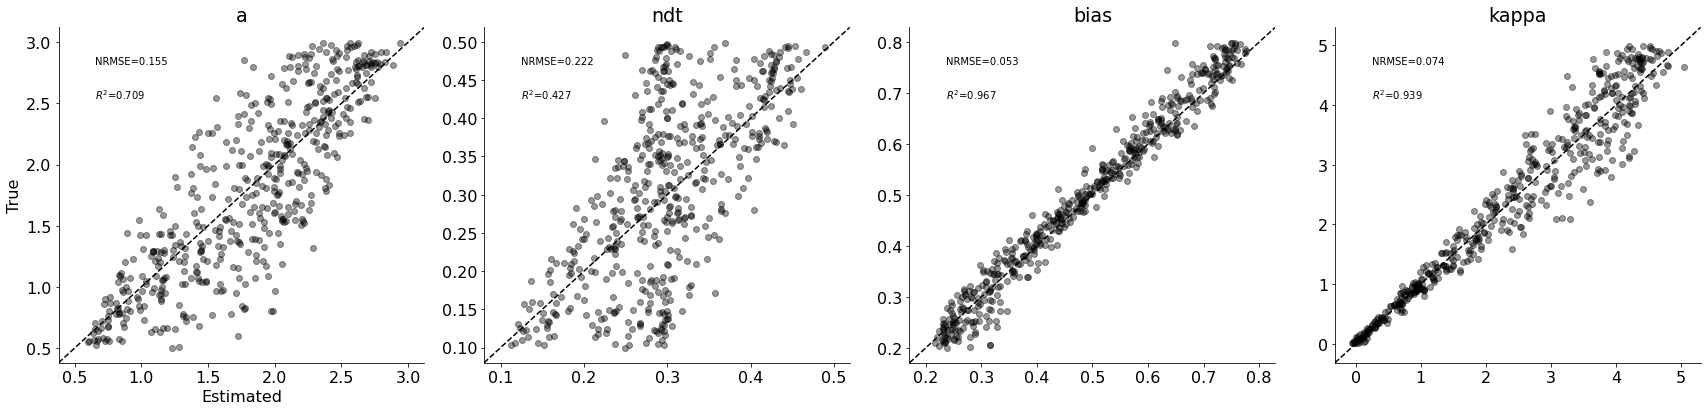

In [9]:
# Recovery plot
f = true_vs_estimated(theta_true=p_, theta_est=param_means,
                  param_names=PARAM_NAMES, dpi=300, figsize=(24,6),font_size=16)

In [ ]:
# Simulate
n_sbc = 5000
n_post_samples_sbc = 250
params, sim_data = const_dm_batch_simulator(n_sbc, N_OBS)

In [ ]:
# Amortized inference
param_samples = np.concatenate([amortizer.sample(x, n_post_samples_sbc)
                                for x in tf.split(sim_data, 10, axis=0)], axis=0)

In [ ]:
# Rank-plot
f = plot_sbc(param_samples, params, param_names=PARAM_NAMES, figsize=(24, 8), bins=23)

## Bayesian Eye Chart

In [ ]:
# Simulation
true_params, sim_data = const_dm_batch_simulator(N_SIM, N_OBS)

# Amortized inference
param_samples = np.concatenate([amortizer.sample(x, N_SAMPLES)
                                for x in tf.split(sim_data, 10, axis=0)], axis=0)

In [ ]:
### Posterior z-score
# Compute posterior means and stds
post_means = param_samples.mean(1)
post_stds = param_samples.std(1)
post_vars = param_samples.var(1)

# Compute posterior z score
post_z_score = (post_means - true_params) / post_stds

### Posterior contraction, i.e., 1 - post_var / prior_var
prior_a = (0.5, 0.1, 0.2, 0.0) # lower bound of uniform prior
prior_b = (3.0, 0.5, 0.8, 5.0) # upper bound of uniform prior

# Compute prior vars analytically
prior_vars = np.array([(b-a)**2/12 for a,b in zip(prior_a, prior_b)])
post_cont = 1 - post_vars / prior_vars

# Plotting time
f, axarr = plt.subplots(1, 4, figsize=(24, 6))
for i, (p, ax) in enumerate(zip(PARAM_NAMES, axarr.flat)):


    ax.scatter(post_cont[:, i], post_z_score[:, i], color='#8f2727', alpha=0.7)
    ax.set_title(p, fontsize=20)
    sns.despine(ax=ax)
    ax.set_xlim([-0.1, 1.05])
    ax.set_ylim([-3.5, 3.5])
    ax.grid(color='black', alpha=0.1)
    ax.set_xlabel('Posterior contraction', fontsize=14)
    if i == 0 or i == 3:
        ax.set_ylabel('Posterior z-score', fontsize=14)
f.tight_layout()

## Posterior Retrodictive Checks

### Empirical Data Preparation

In [10]:
# read data
directory = str(Path().absolute())
path = str(Path(directory).parents[0]) + '/data/single_sub_data.csv'
data = np.loadtxt(open(path, 'rb'), delimiter=",", skiprows=1)

# subset data
data_subset = data[(data[:, 1] == 1) & (data[:, 2] == 1)]

# get one hot encoded amplitude
amplitude = data_subset[:, 4]
condition = get_hot_encoded_amplitude(amplitude)

# prepare data for amortized inference
final_data = np.hstack((np.expand_dims(data_subset[:, 6], axis=1),
                        np.expand_dims(data_subset[:, 5], axis=1), condition))

final_data = np.expand_dims(final_data, axis=0)

final_data.shape

(1, 100, 12)

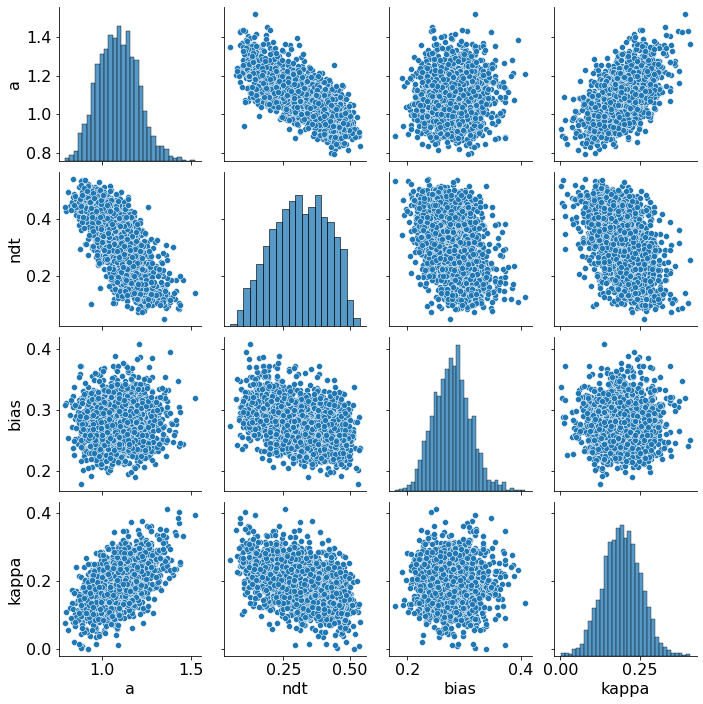

In [11]:
samples = amortizer.sample(final_data, n_samples=N_SAMPLES)
sns.pairplot(pd.DataFrame(samples, columns=PARAM_NAMES))

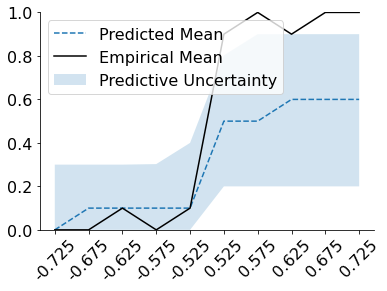

In [23]:
emp_data = data_subset[:, -3:]
pred_data = const_dm_pp_check(emp_data, samples)

In [16]:
n_sim = samples.shape[0]
n_obs = final_data.shape[1]
amplitude = np.round(data_subset[:, 4], 3)
condition = final_data[:, 2:]
pred_data = const_dm_simulator_pp_check(samples, amplitude, condition, n_sim, n_obs)

In [17]:
quantiles = np.quantile(pred_data, [0.025, 0.5, 0.975], axis=0)

In [18]:
unique_amplitude = np.sort(np.unique(amplitude))
emp_resp_prop = np.empty(10)


for i in range(len(unique_amplitude)):
    tmp_data = data_subset[(np.round(data_subset[:, 4], 3) == unique_amplitude[i]), 5]
    emp_resp_prop[i] = tmp_data.mean()

In [20]:
emp_resp_prop.shape

(10,)

ValueError: x and y must have same first dimension, but have shapes (10,) and (100, 3)

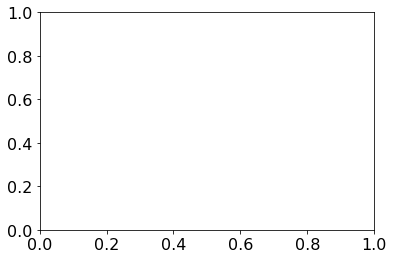

In [15]:
unique_amplitude = np.sort(np.unique(amplitude))
plt.plot(range(len(unique_amplitude)), quantiles[1], linestyle='dashed')
plt.xticks(range(len(unique_amplitude)), unique_amplitude, rotation=45)
plt.fill_between(range(len(unique_amplitude)), quantiles[0], quantiles[2],
                    alpha=0.2, label="Predictive Uncertainty")
plt.ylim([0.0, 1.0])
sns.despine()

In [ ]:
tmp_data = data_subset[(np.round(data_subset[:, 4], 3) == unique_amplitude[0]), 5]
tmp_data